# Bad Control of Intermediate Outcomes
Julian Hsu

21apr2023

The purpose of this script is to demonstrate the bias that comes from controlling for an intermediate outcome that also influences the final outcome of interest. This is commonly studied in Directed Acyclic Graphs (DAGs) and we are covering it through a potential outcomes framework here.



### Potential Outcomes Framework
Suppose we have two outcomes:
$$ Y_i = \tau_1 W_i + \gamma G_i + \beta_1 X_i  + \epsilon_i $$
$$ G_i = \tau_0 W_i  + \beta_0 X_i  + \eta_i $$

Where $\gamma$ is the impact of $G_i$ on $Y_i$ and $\tau_1$ and $\tau_0$ are the impacts of $W_i$ on $Y_i$ and $G_i$, respectively. This means that $G_i$ is an intermediate outcome that is impacted by $W_i$ **and** directly impacts $W_i$. This means that $W_i$ directly impacts $Y_i$ and indirectly impacts $G_i$.

Examples of this include:
* (From labor economics): the impact of schooling on wages, where schooling can directly impact wages and indirectly impact wages through occupational choice;
* (Commerce): the impact of changing the product price, where price directly impacts whether the customer purchases it, and indirectly impacts what else customers purchase, or come back to the store; 
* (Online CX): the impact of an advertising campaign, which can directly increase sales by increasing conversion rate of customers, and indirectly increase sales by bringing in customers that would have converted at competitors.

**This may not always be a bad thing.** It depends on whether you are interested in the *total impact* ($\tau_1 +  \gamma\tau_0 $), or just the *direct impact* ($\tau_1$). If you are interested in rolling out or launching something based on the analysis, then you care about the *total impact.* If you want to decompose what is driving the total impact, you can study the *direct impact* as an option.

All these things inform what sort of regression you are running. You can either:
1. **Control for $G_i$:** which only allows you to estimate the *direct impact*;
2. **Not control for $G_i$**: which estimates the *total impact.*



Let's see how approach 1. can probably give you an unbiased estimate of the direct impact. Let's look at the equations above.

Suppose we control $G_i$ in our regression. While this may seem a-okay at first, we notice that $G_i$ is also a function of $W_i$. This means that $W_i$ affects $Y_i$ directly and through $G_i$. Therefore, we cannot interpret the estimated coefficient on $W_i$ by itself, because whenever $W_i$ moves, so does $G_i$. 

Suppose that we directly control for $G_i$ in a regression:
$$  Y_i = \hat{\tau}_1 W_i + \hat{\gamma} G_i + \hat{\beta_1} X_i  + \epsilon_i $$ 
We can substitute in $G_i$:
$$  Y_i = \hat{\tau}_1 W_i + \hat{\gamma} (\hat{\tau_0} W_i + \hat{\beta_0}X_i + \eta_i )  + \hat{\beta_1} X_i  + \epsilon_i $$ 
This looks like a mess, but we can regroup these as coefficients estimated on $W_i$ and $X_i$:
$$  Y_i = (\hat{\tau}_1 +  \hat{\gamma} \hat{\tau_0} ) W_i + ( \hat{\beta_1} + \hat{\gamma} \hat{\beta_0} ) X_i  + \gamma \eta_i + \epsilon_i $$ 

This means that whenever $W_i$ changes, it will directly impact $Y_i$ by $\tau_1$ and impact it by the indirect impact of $\gamma \tau_0$. The greater this indirect impact relative to the direct impact, the most bias we will see in trying to estimate the direct impact by itself. 

**Recommendation**: Do not isolate the direct impact unless you believe the indirect impact has a very small influence compared to the direct impact. In this case though, it may not be worth accounting for it. We can directly try to take this interaction into account to estimate the direct impact. However, this would not represent the true use case because if you were to launch $W_i$ widely, what you care about is the total impact.





**Soundbyte:** 
I have admittedly gone back and forth about the risks from controlling for an intermediate outcome. A treatment can directly impact your outcome, or indirectly impace it through an intermediate outcome (via a causal pathway). The general recommendation is not to control for them, but I struggled with why. (Example).

Simulations and some algebra made it clear to me that (A) it is hard to justify when you only want to know the direct impact from a treatment and not the total impact; and (B) the larger the indirect impact is, the more biased your estimate of the direct impact will be. This is because your treatment is structurally correlated with your intermediate outcome, so it is very difficult to separate their independent relations on the outcome. Usually, what we care about is the total impact rather than the direct impact, meaning controlling for an intermediate outcome should be edge cases and treated with high scrutiny. 

Check out the simulation notebook here! (link)

In [93]:
import numpy as np
import pandas as pd

%matplotlib inline

import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns

## Import causal models
## https://github.com/shoepaladin/statanomics
import stnomics as stn

from sklearn.linear_model import LogisticRegression, LinearRegression
from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor


### Create functions that generate simulated data
*tau0 - part of the indirect impact
*tau1 - the direct impact
*gamma - part of the indirect impact

In [119]:
## Create two DGPs, one where G is continuous and G is binary

def dgp(N=1000, tau0=0, tau1=0, gamma=0, gerr_var=0.25):
    X = np.random.uniform(-1,1,N)
    W = ( np.exp(X)/(1 + np.exp(X)) + np.random.uniform(-1,1, N) < 0.50 ).astype(float)
    
    G = tau0 * W + np.random.uniform(-1,1)*X + np.random.normal(0,gerr_var,N)
    
    Y = tau1 * W + gamma*G + np.random.uniform(-1,1)*X + np.random.normal(0,1,N)
    totalimpact = tau1 + tau0*gamma

    return pd.DataFrame(data={'x':X, 'w':W, 'g':G, 'y':Y , 'direct':tau1, 'indirect':tau0*gamma})

def dgp_gind(N=1000, tau0=0, tau1=0, gamma=0, gerr_var=0.25):
    X = np.random.uniform(-1,1,N)
    W = ( np.exp(X)/(1 + np.exp(X)) + np.random.uniform(-1,1, N) < 0.50 ).astype(float)
    
    G = tau0 * W + np.random.uniform(-1,1)*X + np.random.normal(0,gerr_var,N)
    G = ( np.exp(G)/(1 + np.exp(G)) + np.random.uniform(-1,1, N) < 0.50 ).astype(float)
    
    Y = tau1 * W + gamma*G + np.random.uniform(-1,1)*X + np.random.normal(0,1,N)
    totalimpact = tau1 + tau0*gamma

    return pd.DataFrame(data={'x':X, 'w':W, 'g':G, 'y':Y , 'direct':tau1, 'indirect':tau0*gamma})



### Model the impacts of W and G separately

In [95]:

df_sim = pd.DataFrame()
i = 0
t_list = np.arange(0.50, 4.50+0.01, 1)
g_list = np.arange(1, 5+0.01, 2)
for t0 in t_list:
    for t1 in t_list:
        for g in g_list:
            for s in range(50):
                df = dgp(tau0 = t0, tau1=t1, gamma=g, gerr_var=1)

                plm_g = stn.ate.dml.dml_plm(data_est=df,
                                           split_name='splits',
                                           feature_name = ['x','g'],
                                           outcome_name = 'y',
                                           treatment_name = 'w',
                                           ymodel = LinearRegression(),
                                           tmodel = LogisticRegression(random_state=2, C=1, penalty='none'),
                                           n_data_splits=4,
                                           aux_dictionary={'lower':0,
                                                          'upper':1})
                plm_ng = stn.ate.dml.dml_plm(data_est=df,
                                           split_name='splits',
                                           feature_name = ['x'],
                                           outcome_name = 'y',
                                           treatment_name = 'w',
                                           ymodel = LinearRegression(),
                                           tmodel = LogisticRegression(random_state=2, C=1, penalty='none'),
                                           n_data_splits=4,
                                           aux_dictionary={'lower':0,
                                                          'upper':1})

                df_sim = pd.concat([df_sim, pd.DataFrame(index=[i], data={'with G': plm_g['ATE TE'], 
                                                               'no G': plm_ng['ATE TE'],
                                                                'with G SE': plm_g['ATE SE'],
                                                                'no G SE': plm_ng['ATE SE'],
                                                               'total impact': t1 + t0*g,
                                                                'gamma': g, 
                                                                'tau0':t0, 'tau1':t1,
                                                              'indirect impact':t0*g,
                                                              'direct impact':t1})])
                i+=1

In [123]:
df_sim['total impact bias MAPE']  = np.abs(df_sim['total impact'] - df_sim['no G']   ) / df_sim['total impact']
df_sim['direct impact bias MAPE'] = np.abs(df_sim['direct impact'] - df_sim['with G']) / df_sim['direct impact']

df_sim_agg = df_sim.groupby(['gamma','tau0','tau1']).mean()

df_sim_agg.reset_index(inplace=True)
# df_sim_agg.describe()
print ( 
df_sim_agg[['total impact bias MAPE', 'direct impact bias MAPE','with G','gamma','tau0', 'tau1','indirect impact']].corr()[['total impact bias MAPE','direct impact bias MAPE']] )

                         total impact bias MAPE  direct impact bias MAPE
total impact bias MAPE                 1.000000                -0.188495
direct impact bias MAPE               -0.188495                 1.000000
with G                                -0.260620                -0.578404
gamma                                  0.144835                 0.012613
tau0                                  -0.732609                 0.474625
tau1                                  -0.276943                -0.567792
indirect impact                       -0.458022                 0.321992


In [139]:
print(plt.style.available)

['Solarize_Light2', '_classic_test_patch', '_mpl-gallery', '_mpl-gallery-nogrid', 'bmh', 'classic', 'dark_background', 'fast', 'fivethirtyeight', 'ggplot', 'grayscale', 'seaborn', 'seaborn-bright', 'seaborn-colorblind', 'seaborn-dark', 'seaborn-dark-palette', 'seaborn-darkgrid', 'seaborn-deep', 'seaborn-muted', 'seaborn-notebook', 'seaborn-paper', 'seaborn-pastel', 'seaborn-poster', 'seaborn-talk', 'seaborn-ticks', 'seaborn-white', 'seaborn-whitegrid', 'tableau-colorblind10']


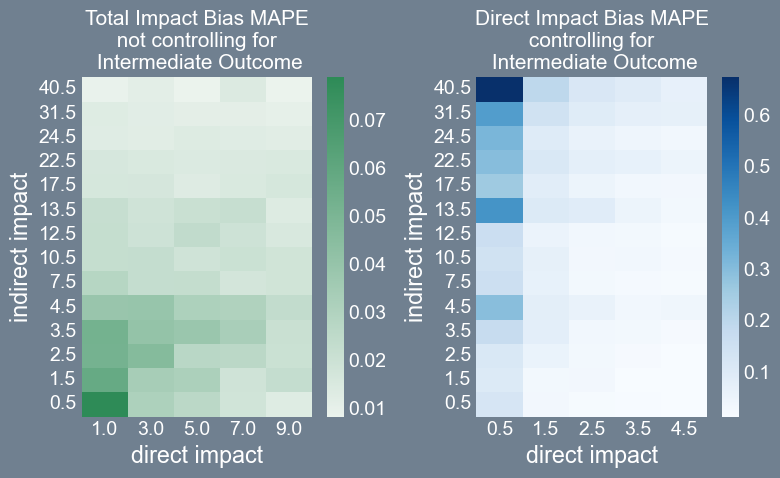

In [161]:
plot_1 = pd.pivot(df_sim.groupby(['gamma','tau0']).mean().reset_index(), 
                 columns=['gamma'], index=['tau0'], values=['total impact bias MAPE'])

plot_1 = pd.pivot(df_sim.groupby(['direct impact','indirect impact']).mean().reset_index(), 
                 columns=['direct impact'], index=['indirect impact'], values=['total impact bias MAPE'])


plot_2 = pd.pivot(df_sim.groupby(['direct impact','indirect impact']).mean().reset_index(), 
                 columns=['direct impact'], index=['indirect impact'], values=['direct impact bias MAPE'])

fig,ax = plt.subplots(ncols=2,nrows=1,figsize=(8,5))
sns.heatmap(plot_1.sort_index(ascending=False), cmap=sns.light_palette("seagreen", as_cmap=True),
            xticklabels = g_list, ax=ax[0])
sns.heatmap(plot_2.sort_index(ascending=False), cmap=sns.color_palette("Blues", as_cmap=True),
            xticklabels = t_list, ax=ax[1])

ax[0].set_title('Total Impact Bias MAPE\n not controlling for \n Intermediate Outcome', fontsize=15)
ax[0].set_xlabel('direct impact')
ax[0].set_ylabel('indirect impact')

ax[1].set_title('Direct Impact Bias MAPE\n controlling for \n Intermediate Outcome', fontsize=15)
ax[1].set_xlabel('direct impact')
ax[1].set_ylabel('indirect impact')

plt.tight_layout()

plt.style.use('bmh')
fig.set_facecolor('slategray')
plt.show()






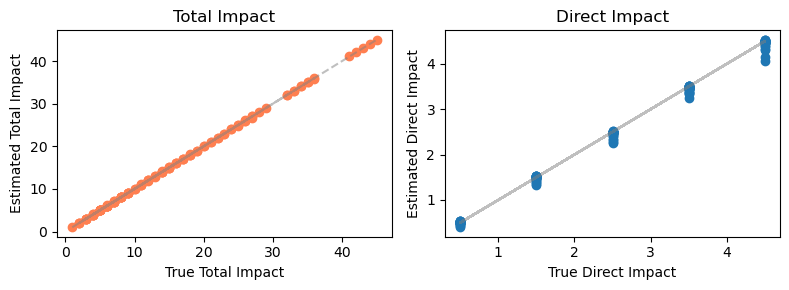

In [125]:
fig,ax = plt.subplots(ncols=2,nrows=1, figsize=(8,3))
ax[0].scatter(df_sim_agg['total impact'], df_sim_agg['no G'], color='coral')
ax[0].plot(df_sim_agg['total impact'], df_sim_agg['total impact'], color='grey', alpha=0.50, linestyle='dashed')
ax[0].set_xlabel('True Total Impact')
ax[0].set_ylabel('Estimated Total Impact')
ax[0].set_title('Total Impact')

ax[1].scatter(df_sim_agg['direct impact'],
             df_sim_agg['with G'])
ax[1].plot(df_sim_agg['direct impact'], df_sim_agg['direct impact'], color='grey', alpha=0.50, linestyle='dashed')

ax[1].set_xlabel('True Direct Impact')
ax[1].set_ylabel('Estimated Direct Impact')
ax[1].set_title('Direct Impact')


plt.tight_layout()
plt.show()

# for g in df_sim_agg['G error var'].unique():
#     if g > 0.05:
#         erg = df_sim_agg.loc[df_sim_agg['G error var']==g].groupby(['direct impact'])['with G'].mean().reset_index()
# #         erg = df_sim_agg.loc[df_sim_agg['G error var']==g]
#         ax[1].scatter(erg['direct impact'], erg['with G'], alpha=0.55,
#                       label='{0:3.2f}'.format(g))

# ax[1].legend(title='Variance of Error in G')

